4/4 ━━━━━━━━━━━━━━━━━━━━ 117s 23s/step
Number of failed predictions: 6
True label: 2, Predicted label: 1


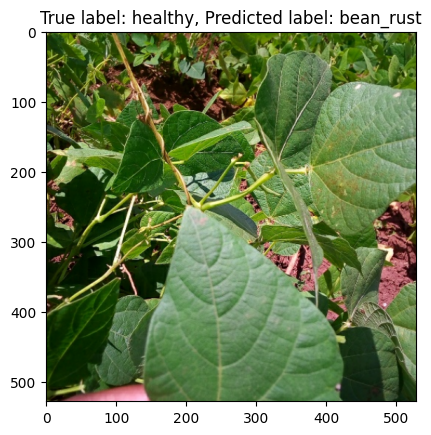

True label: 0, Predicted label: 1


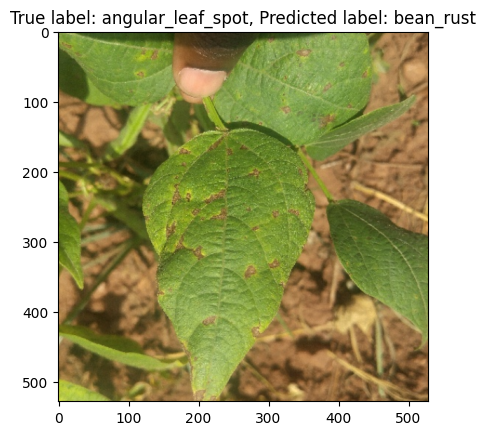

True label: 0, Predicted label: 1


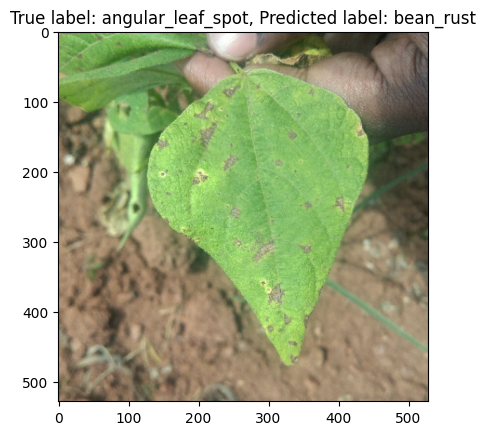

True label: 1, Predicted label: 0


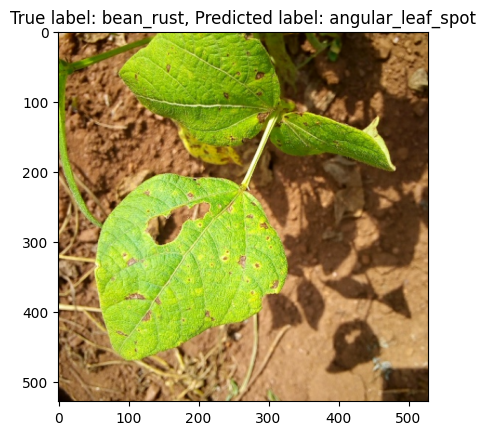

True label: 0, Predicted label: 1


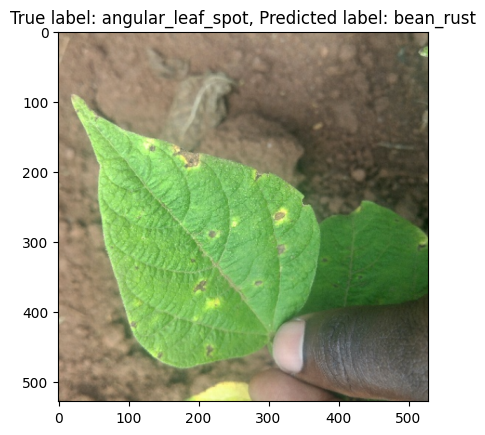

True label: 1, Predicted label: 0


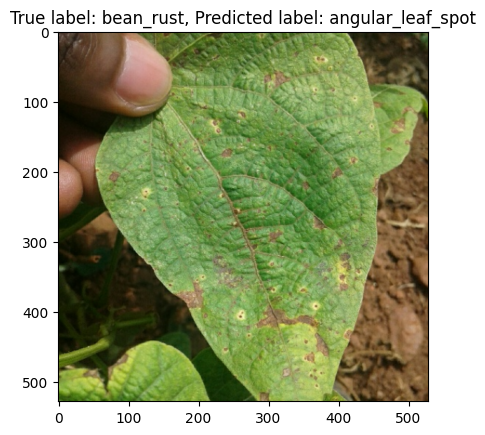

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('my_model.keras')

# Load the test dataset
ds_test, info = tfds.load('beans', split='test', with_info=True, as_supervised=True)
IMG_SIZE = 528
size = (IMG_SIZE, IMG_SIZE)
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
class_names = info.features['label'].names

# Initialize lists to hold features and labels
X_test = []
y_test = []

# Iterate through the dataset and split into X and y
for image, label in tfds.as_numpy(ds_test):
    X_test.append(image)
    y_test.append(label)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Make predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Identify failed predictions
failed_indices = np.where(predicted_labels != y_test)[0]

# Print failed images and their true labels
print("Number of failed predictions:", len(failed_indices))
for idx in failed_indices:
    true_label_name = class_names[y_test[idx]]
    predicted_label_name = class_names[predicted_labels[idx]]
    print(f"True label: {y_test[idx]}, Predicted label: {predicted_labels[idx]}")
    plt.imshow(X_test[idx].astype("uint8"))
    plt.title(f"True label: {true_label_name}, Predicted label: {predicted_label_name}")
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 11s/step
Number of failed predictions: 6
True label: healthy, Predicted label: bean_rust


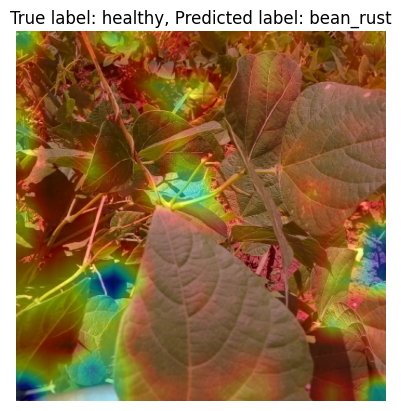

True label: angular_leaf_spot, Predicted label: bean_rust


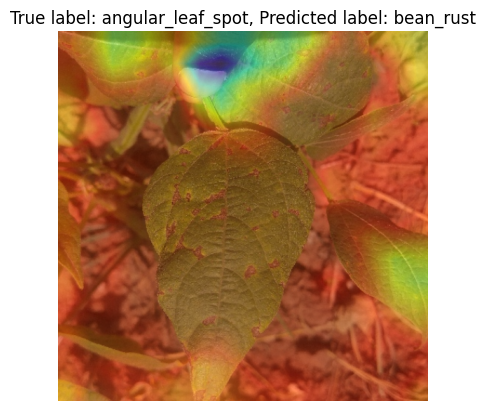

True label: angular_leaf_spot, Predicted label: bean_rust


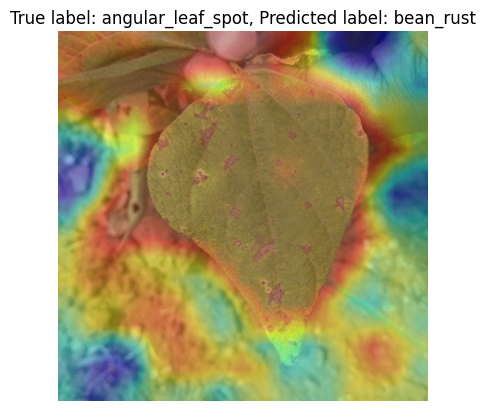

True label: bean_rust, Predicted label: angular_leaf_spot


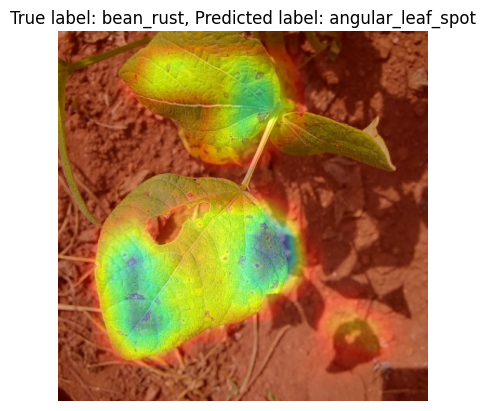

True label: angular_leaf_spot, Predicted label: bean_rust


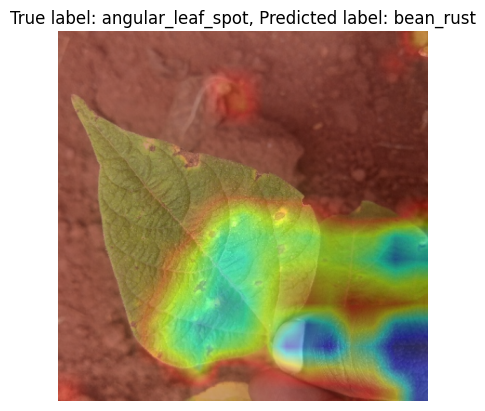

True label: bean_rust, Predicted label: angular_leaf_spot


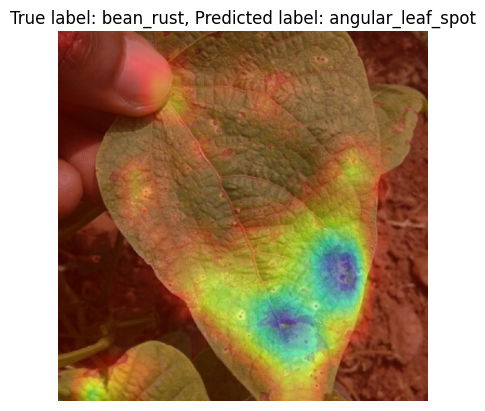

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the model
model = tf.keras.models.load_model('my_model.keras')

# Load the test dataset
ds_test, info = tfds.load('beans', split='test', with_info=True, as_supervised=True)
IMG_SIZE = 528
size = (IMG_SIZE, IMG_SIZE)
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

class_names = info.features['label'].names

X_test = []
y_test = []

for image, label in tfds.as_numpy(ds_test):
    X_test.append(image)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Identify failed predictions
failed_indices = np.where(predicted_labels != y_test)[0]

# Function to generate Grad-CAM heatmap
def get_gradcam_heatmap(model, image, class_idx, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to overlay heatmap on image
def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlayed_image

# Print failed images with overlay heatmap and their true labels
print("Number of failed predictions:", len(failed_indices))
for idx in failed_indices:
    true_label_name = class_names[y_test[idx]]
    predicted_label_name = class_names[predicted_labels[idx]]
    print(f"True label: {true_label_name}, Predicted label: {predicted_label_name}")
    last_conv_layer_name = 'top_conv'
    # Generate Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(model, X_test[idx], predicted_labels[idx], last_conv_layer_name)  # Replace 'conv2d' with the name of the last convolutional layer in your model
    
    # Overlay heatmap on image
    overlayed_image = overlay_heatmap(X_test[idx].astype("uint8"), heatmap)
    
    # Display the image with heatmap
    plt.imshow(overlayed_image)
    plt.title(f"True label: {true_label_name}, Predicted label: {predicted_label_name}")
    plt.axis('off')
    plt.show()